In [3]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

import caffe
from caffe import layers as L
caffe.set_mode_gpu()

import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt


# Instantiate network

In [197]:
reload(mcl.nets.scatnet_net)


scale = 3
scales = 2**np.arange(0,scale)
max_order = 3
nangles = 4
filter_size_factor = 4


if 'net' in locals():
    del net
net = scatnet(nchannels_input=3,
              scales=scales,
              max_order=max_order,
              nangles=nangles,
              filter_size_factor=filter_size_factor,)



In [198]:
img = scipy.misc.imread('data/train/4013.jpg')[:600,:600,:]
img = scipy.misc.imresize(img,size=(256,256))
img = img.transpose(2,0,1)

img = img[:,:,:]
img_input = img[np.newaxis, ...].copy()


for _ in range(0):
    img_input = np.append(img_input, img_input, 0)

net.blobs['data'].reshape(*img_input.shape)
net.blobs['data'].data[...] = img_input
net.blobs['data'].data.shape

im = np.squeeze(net.blobs['data'].data).transpose(1,2,0)

# Process data

In [199]:
%%time
caffe.set_mode_gpu()
caffe.set_device(0)
for _ in range(1):
    net.forward()
pass

CPU times: user 108 ms, sys: 32 ms, total: 140 ms
Wall time: 140 ms


In [200]:
def norm(tmp):    
    for l in range(tmp.shape[0]):
        mx = tmp[l].max()
        if mx == 0:
            continue
        if mx == np.inf:
            tmp[l] = 0
            continue
        tmp[l] /= mx
    return tmp

In [201]:
import operator
def get_layers_sizes(nangles,
                    max_order,
                    scales,
                    nchannels_input=3):
    
    
    dim_total = nchannels_input
    layers = [[(dim_total, 0)]]
    for o in range(max_order):
        layer = []
        for s in scales:
            for c0, s0 in layers[-1]:
                if s0 is not None and s <= s0:
                    continue
                dim_out = nchannels_input * nangles ** (o + 1)
                dim_total += dim_out

                layer.append((dim_out, s))

        layers.append(layer)
    steps = [x/3 for x in zip(*reduce(operator.add, layers))[0]]


    mask = np.zeros(dim_total, dtype='int')
    i = 0
    for d in steps:
        for c in range(nchannels_input):
            mask[i:i+d] = c
            i += d
    
    return mask


In [202]:
output = np.squeeze(net.blobs['output'].data[0,:,:,:])
scat_dim = output.shape[0]

tmp = output[:,::,::,np.newaxis].copy()
print tmp.shape

mask = get_layers_sizes(nangles, max_order, scales, nchannels_input=3)

#tmp = np.concatenate([tmp[::3],tmp[1::3],tmp[2::3]],3)
#tmp = np.concatenate([tmp[1::3],tmp[1::3],tmp[1::3]],3)
tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
#tmp = np.concatenate(tmp_rgb,3)



(375, 54, 54, 1)


In [203]:
def show_output(net, indx=0):
    output = np.squeeze(net.blobs['output'].data[indx,:,:,:])
    tmp = output[:,::,::,np.newaxis].copy()
    mask = get_layers_sizes(nangles, max_order, scales, nchannels_input=3)
    tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
    vis_square(norm(tmp[0:]))

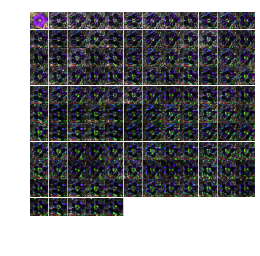

In [204]:
show_output(net)

# Prepare input

In [205]:
train_data_path = os.path.join(plant_clef_root, 'data', 'train.txt')
test_data_path = os.path.join(plant_clef_root, 'data', 'test.txt')


transform_param = dict(mirror=False, crop_size=227)
species_data, species_label = L.ImageData(transform_param=transform_param,
                                          source=train_data_path,
                                          batch_size=1,
                                          new_height=256,
                                          new_width=256,
                                          ntop=2)

In [206]:

if 'net' in locals():
    del net
net = scatnet(data=species_data, scales=scales, max_order=max_order, nangles=nangles, filter_size_factor=filter_size_factor)



In [207]:
n_samples = 1000
mean_values = np.zeros([n_samples, scat_dim], dtype='single')

t0 = time.time()
for i in range(n_samples):
    net.forward()
    data = np.mean(np.mean(net.blobs['output'].data,2),2)
    mean_values[i,:] = data.ravel()
    if not i % 100:
        t = time.time() - t0
        print "%5i: %.1f images per second" % (i, float(i) / t)
    

    0: 0.0 images per second
   10: 8.6 images per second
   20: 9.0 images per second
   30: 9.1 images per second
   40: 9.2 images per second
   50: 9.3 images per second
   60: 9.3 images per second
   70: 9.3 images per second
   80: 9.3 images per second
   90: 9.4 images per second
  100: 9.4 images per second
  110: 9.4 images per second
  120: 9.4 images per second
  130: 9.4 images per second
  140: 9.4 images per second
  150: 9.4 images per second
  160: 9.4 images per second
  170: 9.4 images per second
  180: 9.4 images per second
  190: 9.4 images per second
  200: 9.4 images per second
  210: 9.4 images per second
  220: 9.4 images per second
  230: 9.4 images per second
  240: 9.4 images per second
  250: 9.4 images per second
  260: 9.4 images per second
  270: 9.4 images per second
  280: 9.4 images per second
  290: 9.4 images per second
  300: 9.4 images per second
  310: 9.4 images per second
  320: 9.4 images per second
  330: 9.4 images per second
  340: 9.4 ima

In [210]:
scipy.save('/home/ffw/s3m3a4',np.mean(mean_values,0))


In [171]:
%%time
net.forward()
data = np.mean(np.mean(net.blobs['output'].data,2),2)

CPU times: user 332 ms, sys: 28 ms, total: 360 ms
Wall time: 334 ms


In [165]:
%%time
net.forward();
pass

CPU times: user 304 ms, sys: 32 ms, total: 336 ms
Wall time: 325 ms


In [143]:
print net.blobs['output'].data.shape
np.prod(net.blobs['output'].data.shape[1:])

(2, 648, 47, 47)


1431432

In [144]:
36000*len(net.blobs['output'].data[0,...].astype('uint8').tobytes()) * 2**-30

47.99249768257141

In [54]:
%%time
v = net.blobs['output'].data.astype('single')

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.64 ms


In [30]:
net.blobs['output'].data.min()

0.00084530876

In [91]:

net.blobs['output'].data.astype('single').shape

(2, 648, 47, 47)

In [100]:
data = net.blobs['output'].data

In [134]:
data_t = (255*((data / 255)**.2)).astype('uint8')

In [170]:
648 * 3600 * 2**-20

2.2247314453125